In [7]:
# Imports
import pandas as pd
import yfinance as yf
import hvplot.pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import glob
import cufflinks as cf
import scipy.stats as stats
import scipy.optimize as sp_optimize
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [8]:
# Imports
plt.style.use("seaborn")
cf.set_config_file(offline = True)
%matplotlib inline


# Cleaning Data, visualization and heatmap

In [9]:
Sp_dix_gex_df = pd.read_csv("DIX.csv", parse_dates=True, infer_datetime_format=True, index_col="date")

In [10]:
vix_df = yf.download("^VIX", start="2011-05-02", end= "2022-11-11")['Close']#.rename({"Close":"VIX", axis=1, inplace=True})

[*********************100%***********************]  1 of 1 completed


In [11]:
gamma_dix_df = pd.concat([Sp_dix_gex_df, vix_df], axis = 1).rename(columns={"Close":"VIX","price":"sp500"}).dropna()
display(gamma_dix_df.head())
display(gamma_dix_df.tail())

,sp500,dix,gex,VIX
2011-05-02,1361.219971,0.378842,1.897313e+09,15.990000
2011-05-03,1356.619995,0.383411,1.859731e+09,16.700001
2011-05-04,1347.319946,0.392122,1.717764e+09,17.080000
2011-05-05,1335.099976,0.405457,1.361864e+09,18.200001
2011-05-06,1340.199951,0.418649,1.490329e+09,18.400000


,sp500,dix,gex,VIX
2022-11-04,3770.550049,0.425303,5.863258e+08,24.549999
2022-11-07,3806.800049,0.449861,1.164755e+09,24.350000
2022-11-08,3828.110107,0.438960,1.395167e+09,25.540001
2022-11-09,3748.570068,0.457835,4.817286e+07,26.090000
2022-11-10,3956.370117,0.420308,3.748514e+09,23.530001


In [12]:
gamma_dix_df.to_csv("gex_di x_sp500_df_update.csv")

In [13]:
gamma_dix_df["sp500 change"] = gamma_dix_df["sp500"].pct_change()*100

In [14]:
gamma_dix_df.dropna(inplace=True)

In [15]:
gamma_dix_df.to_csv("gamma_dix_df_update.csv")

In [16]:
gamma_dix_df

,sp500,dix,gex,VIX,sp500 change
2011-05-03,1356.619995,0.383411,1.859731e+09,16.700001,-0.337930
2011-05-04,1347.319946,0.392122,1.717764e+09,17.080000,-0.685531
2011-05-05,1335.099976,0.405457,1.361864e+09,18.200001,-0.906984
2011-05-06,1340.199951,0.418649,1.490329e+09,18.400000,0.381992
2011-05-09,1346.290039,0.410321,1.677059e+09,17.160000,0.454416
...,...,...,...,...,...
2022-11-04,3770.550049,0.425303,5.863258e+08,24.549999,1.361872
2022-11-07,3806.800049,0.449861,1.164755e+09,24.350000,0.961398
2022-11-08,3828.110107,0.438960,1.395167e+09,25.540001,0.559789
2022-11-09,3748.570068,0.457835,4.817286e+07,26.090000,-2.077789


In [17]:
gamma_dix_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2903 entries, 2011-05-03 to 2022-11-10
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sp500         2903 non-null   float64
 1   dix           2903 non-null   float64
 2   gex           2903 non-null   float64
 3   VIX           2903 non-null   float64
 4   sp500 change  2903 non-null   float64
dtypes: float64(5)
memory usage: 136.1 KB


In [18]:
gamma_dix_df.describe()

,sp500,dix,gex,VIX,sp500 change
count,2903.000000,2903.000000,2.903000e+03,2903.000000,2903.000000
mean,2524.170933,0.425410,2.638378e+09,18.352256,0.043161
std,941.772583,0.031511,2.843796e+09,7.487284,1.129124
min,1099.229980,0.330555,-7.496823e+09,9.140000,-11.981453
25%,1857.529968,0.403988,1.125406e+09,13.335000,-0.380629
50%,2296.680000,0.423250,2.205509e+09,16.170000,0.059419
75%,3002.735000,0.443394,3.428101e+09,21.240000,0.559629
max,4796.560059,0.551115,2.421867e+10,82.690002,9.382766


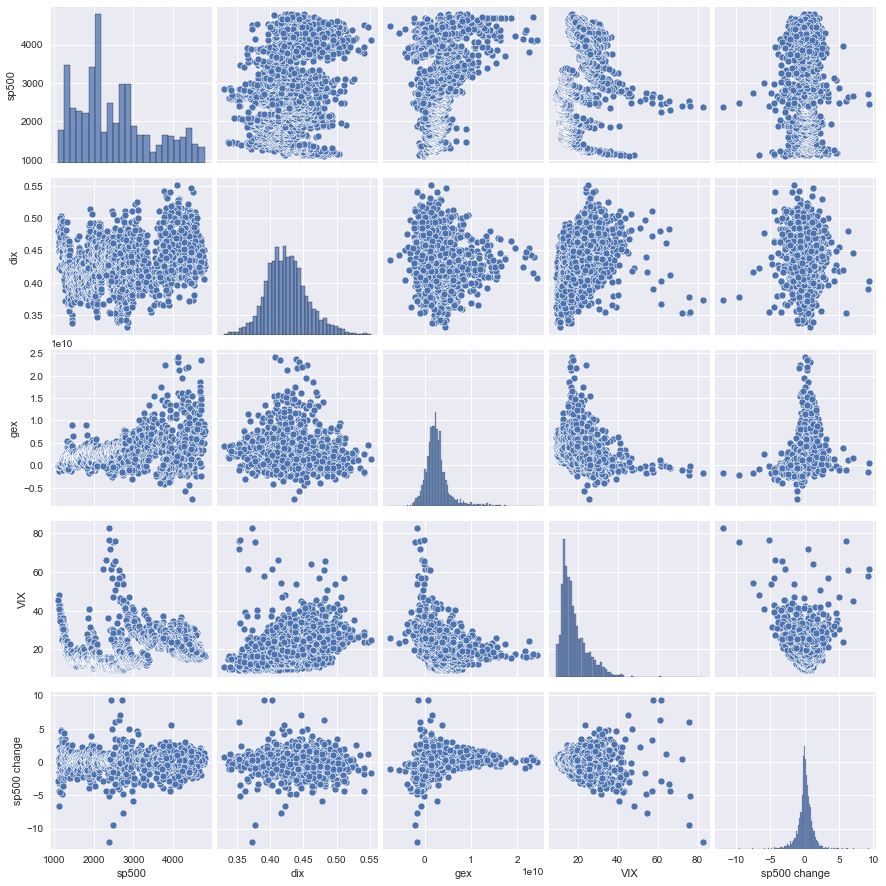

In [19]:
sns.pairplot(gamma_dix_df, kind='scatter')
plt.show()

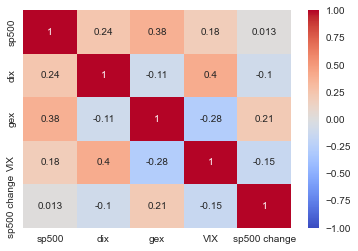

In [20]:
sns.heatmap(gamma_dix_df.corr(),annot=True, cmap="coolwarm", vmin=-1,vmax=1)
plt.show()

In [21]:
colors = np.where(gamma_dix_df["sp500 change"] <0, 'C0', 'C1')

Text(0.5, 1.0, 'SPX Change by GEX level')

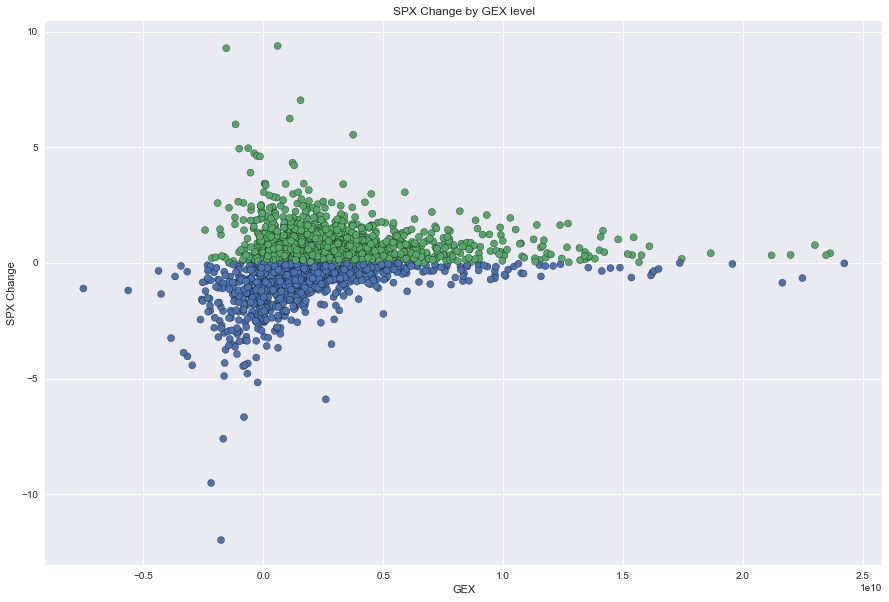

In [22]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10
plt.scatter(x = gamma_dix_df["gex"], y = gamma_dix_df["sp500 change"],cmap = 'Spectral', edgecolor = 'k', c= colors)
plt.xlabel("GEX")
plt.ylabel("SPX Change")
plt.title("SPX Change by GEX level")

In [23]:
# volatility can go up and own 
gamma_dix_df["Implied Move"] = gamma_dix_df["VIX"] / 16
gamma_dix_df["absolute move sp500"] = gamma_dix_df['sp500 change'].abs()
gamma_dix_df["sp500 vix"] = gamma_dix_df["absolute move sp500"] - gamma_dix_df["Implied Move"]

In [24]:
gamma_dix_df

,sp500,dix,gex,VIX,sp500 change,Implied Move,absolute move sp500,sp500 vix
2011-05-03,1356.619995,0.383411,1.859731e+09,16.700001,-0.337930,1.043750,0.337930,-0.705820
2011-05-04,1347.319946,0.392122,1.717764e+09,17.080000,-0.685531,1.067500,0.685531,-0.381969
2011-05-05,1335.099976,0.405457,1.361864e+09,18.200001,-0.906984,1.137500,0.906984,-0.230517
2011-05-06,1340.199951,0.418649,1.490329e+09,18.400000,0.381992,1.150000,0.381992,-0.768008
2011-05-09,1346.290039,0.410321,1.677059e+09,17.160000,0.454416,1.072500,0.454416,-0.618084
...,...,...,...,...,...,...,...,...
2022-11-04,3770.550049,0.425303,5.863258e+08,24.549999,1.361872,1.534375,1.361872,-0.172502
2022-11-07,3806.800049,0.449861,1.164755e+09,24.350000,0.961398,1.521875,0.961398,-0.560477
2022-11-08,3828.110107,0.438960,1.395167e+09,25.540001,0.559789,1.596250,0.559789,-1.036461
2022-11-09,3748.570068,0.457835,4.817286e+07,26.090000,-2.077789,1.630625,2.077789,0.447164


In [25]:
gamma_dix_df['sp500 vix'].mean()

-0.4128112089282491

In [26]:
gamma_dix_df['sp500 vix'].iplot(theme = 'solar')